In [1]:
import yaml
import sys
import os
import os.path
from csv import DictReader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def baseline(time_remaining,separation):
        """
        Returns the baseline aproximate for the given phi value and the current state

        NOTE: In training you should always evaluate for a fixed phi not the phi the agent picks. 

        """
        d_tilde = (dims+2) * (dims-1) * D
        #useful intermediate value used in the baseline mutiple times
        block = NU + 2*PHI - d_tilde
        a = ((BETA + PHI**2)*(1-np.exp(-time_remaining*block)))/block
        b_term1 = dims * kappa * (BETA + PHI**2) / (NU*(2*PHI-d_tilde))
        b_term2 = 1 - np.exp(-NU*time_remaining) - NU * (1-np.exp(-time_remaining*block))/block
        b = b_term1 * b_term2
        return (a*separation**2 + b)

## Load the given config file and run numerics if neeeded

In [3]:
config_file = "default_config_synth"
data_file = f"baseline_CSVs/{config_file}.csv"

with open(f"baseline_config_files/{config_file}.yaml") as cf_file:
    config = yaml.safe_load(cf_file.read())
    
NU = config["NU"] 
kappa = config["kappa"] 
BETA = config["BETA"]
PHI = config["PHI"]
D = config["D"]
delta_t = config["delta_t"]
delta_r = config["delta_r"]
t_end = config["t_end"]
num_eps = config["num_eps"]
dims=2 # batchlor flow implementation is 2d


# if data has already been saved for the given config file no need to run again
if not os.path.isfile(data_file):
    print("Generating data: This may take a while")
    os.system(f'bash gen_data_synth.sh {config_file}')
    
with open(data_file, 'r') as f:
    dict_reader = DictReader(f)
    str_results_dict = list(dict_reader)[0]

## Create a 2d histogram comparing the predicted versus observed rewards

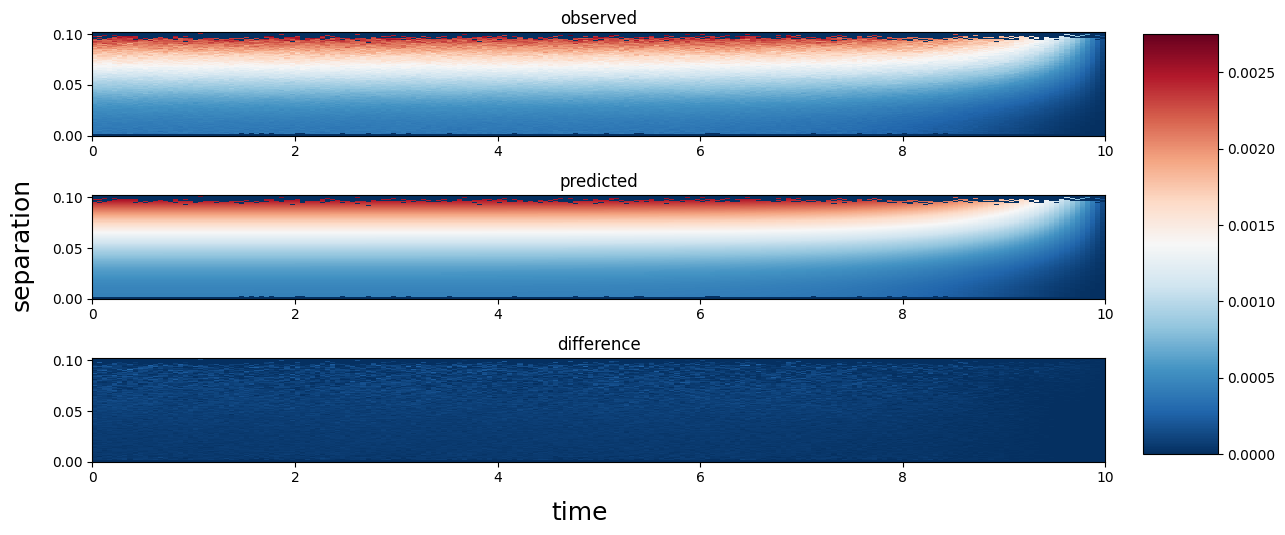

In [4]:

#convert strings to numeric keys and values
results_dict={}
max_ybin = 0
max_x_bins=int(t_end/delta_t)

#The number of samples a pixel needs to be inlcuded in the figure
#Set to 1 if running on small test only
count_threshhold = 100

for key, value in str_results_dict.items():
    key = eval(key)
    value = eval(value)
    results_dict[key]=value
    if value[1] > count_threshhold:
        max_ybin = max(max_ybin,key[1]+1)


sampled = np.zeros([max_ybin,max_x_bins])
evaluated = np.zeros([max_ybin,max_x_bins])


for key, value in results_dict.items():
    if value[1] > count_threshhold:
        time_remaining = t_end - key[0]*delta_t
        sep = key[1]*delta_r
        sampled[key[1]][key[0]] = value[0]/value[1]
        evaluated[key[1]][key[0]] = baseline(time_remaining,sep)
        
        
cmap="RdBu_r"



fig, ax = plt.subplots(3, 1)
minmin = 0.
maxmax = max(sampled.max(),evaluated.max())
scale = ax[0].imshow(np.flip(sampled,axis=0),vmin=minmin, vmax=maxmax, interpolation='nearest', extent = [0 , sampled.shape[1]*delta_t,0,delta_r*sampled.shape[0]], aspect=10,cmap=cmap)
scale2 = ax[1].imshow(np.flip(evaluated,axis=0), vmin=minmin, vmax=maxmax,interpolation='nearest', extent = [0 , sampled.shape[1]*delta_t,0,delta_r*sampled.shape[0]], aspect=10,cmap=cmap)
scale3 = ax[2].imshow(np.abs(np.flip((evaluated-sampled),axis=0)), vmin=minmin, vmax=maxmax,interpolation='nearest', extent = [0 , sampled.shape[1]*delta_t,0,delta_r*sampled.shape[0]], aspect=10,cmap=cmap)
fig.set_size_inches(15,6)


ax[0].set_title("observed")
ax[1].set_title("predicted")
ax[2].set_title("difference")


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.825, 0.15, 0.05, 0.7])
fig.colorbar(scale, cax=cbar_ax)
fig.text(0.45, 0.04, 'time', ha='center',size=18)
fig.text(0.07, 0.5, 'separation', va='center', rotation='vertical',size=18)
plt.savefig(f"PDFs/synth_{config_file}.pdf", format="pdf", bbox_inches="tight")